Must install `imagecodecs` using pip __not__ conda!  (See [this issue](https://github.com/cgohlke/imagecodecs/issues/29))

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from imagecodecs.numcodecs import JpegXl
import numcodecs
from numcodecs.registry import register_codec

register_codec(JpegXl)  # IMPORTANT!

plt.rcParams["figure.figsize"] = (20, 12)

In [2]:
SRC_SATELLITE_ZARR_PATH = "gs://public-datasets-eumetsat-solar-forecasting/satellite/EUMETSAT/SEVIRI_RSS/v3/eumetsat_seviri_hrv_uk.zarr" 

In [3]:
satellite_dataset = xr.open_dataset(
    SRC_SATELLITE_ZARR_PATH, 
    engine="zarr", 
    chunks={},  # Load using Dask, using the same chunks as used in the original Zarr dataset.
)

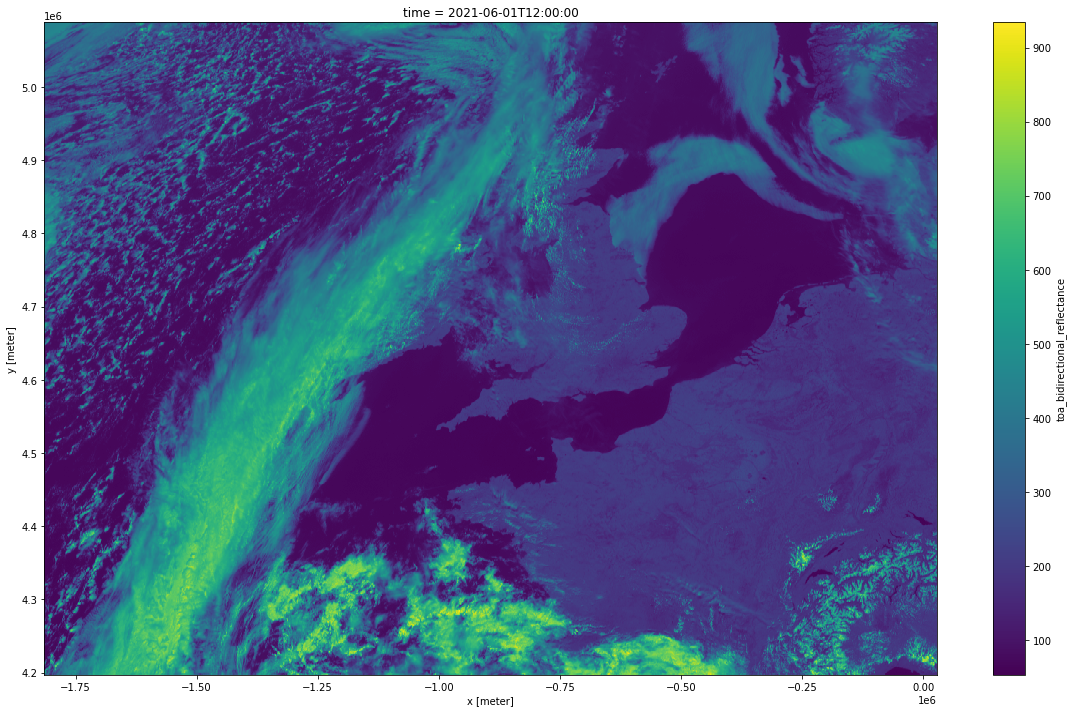

In [4]:
DATETIME_TO_PLOT = "2021-06-01 12:00"
satellite_data_array = satellite_dataset['data']
satellite_data_array.sel(time=DATETIME_TO_PLOT).plot();

```
$cjxl --help

JPEG XL encoder v0.7.0 7613f62 [AVX2,SSE4,SSSE3,Scalar]
Usage: cjxl INPUT OUTPUT [OPTIONS...]
 INPUT
    the input can be PNG, APNG, GIF, JPEG, EXR, PPM, PFM, or PGX
 OUTPUT
    the compressed JXL output file (can be omitted for benchmarking)
 -d maxError, --distance=maxError
    Max. butteraugli distance, lower = higher quality. Range: 0 .. 25.
    0.0 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    1.0 = visually lossless. Default for other input.
    Recommended range: 0.5 .. 3.0.
 -q QUALITY, --quality=QUALITY
    Quality setting (is remapped to --distance). Range: -inf .. 100.
    100 = mathematically lossless. Default for already-lossy input (JPEG/GIF).
    Positive quality values roughly match libjpeg quality.
 -e EFFORT, --effort=EFFORT
    Encoder effort setting. Range: 1 .. 9.
    Default: 7. Higher number is more effort (slower).
 -p, --progressive
    Enable progressive/responsive decoding.
 --resampling=0|1|2|4|8
    Subsample all color channels by this factor, or use 0 to choose the resampling factor based on distance.
 -v, --verbose
    Verbose output; can be repeated, also applies to help (!).
 -h, --help
    Prints this help message (use -v to see more options).

```

In [5]:
MATHEMATICALLY_LOSSLESS_DISTANCE = 0
VISUALLY_LOSSLESS_DISTANCE = 1

In [6]:
satellite_dataset

<xarray.Dataset>
Dimensions:  (time: 173624, y: 891, x: 1843)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01T00:05:00 ... 2021-11-07T15:50:00
  * x        (x) float32 2.8e+04 2.7e+04 2.6e+04 ... -1.813e+06 -1.814e+06
    x_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
  * y        (y) float32 4.198e+06 4.199e+06 4.2e+06 ... 5.087e+06 5.088e+06
    y_osgb   (y, x) float32 dask.array<chunksize=(891, 1843), meta=np.ndarray>
Data variables:
    data     (time, y, x) int16 dask.array<chunksize=(1, 891, 1843), meta=np.ndarray>

In [8]:
class JpegXlMultiTimestep(JpegXl):
    
    codec_id = 'imagecodecs_jpegxl_multi_timestep'
    
    def encode(self, buf):
        """Assumes buf has 3 dims: time, y, x; and that time just has 1 entry.""" 
        assert buf.shape[0] == 1
        buf = buf[0]
        return super().encode(buf)
    
    def decode(self, buf, out=None):
        array = super().decode(buf=buf, out=out)
        return array[np.newaxis, :, :]
        
register_codec(JpegXlMultiTimestep)

In [47]:
(satellite_dataset["data"].sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).clip(min=0).astype(np.uint16) * 2**6
).max().compute()

<xarray.DataArray 'data' ()>
array(59776, dtype=uint16)

In [32]:
2**10 * 2**6

65536

In [25]:
2**16

65536

In [3]:
OUTPUT_ZARR_PATH = "gs://solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/test_jpeg_xl_compression/jpeg_xl_distance_0_effort_9.zarr"

In [ ]:
%%time

encoding = {
    "data": {
        #"compressor": JpegXl(
            # distance: Lowest settings are 0.00 or 0.01.  
        #    distance=0.0,
            
            # level: Set the decoding speed tier for the provided options. Minimum is 0 (highest
            # https://github.com/libjxl/libjxl/blob/v0.6.1/lib/include/jxl/encode.h#L317
            # quality), and maximum is 4 (lowest quality). Default is 0.
            # Leave this as None if distance = 0.0
            # This must be set to 0, 1, 2, 3, or 4 if distance is not 0.00, otherwise distance will have no effect:
            # lossless mode is always enabled if level==None.
        #    level=None,
            
        #    effort=7,
            #photometric=False,
        #),
        "compressor": numcodecs.get_codec(dict(id="bz2", level=5)),
    },
}

# Need to set to 
zarr_store = (satellite_dataset.sel(
    time=[
        "2021-06-01 12:00",
        "2021-06-10 06:00",
        "2021-01-01 09:00",
        "2021-01-01 00:00",
    ]
).clip(min=0) / 4).astype(np.uint8).expand_dims(dim="channel", axis=-1).to_zarr(
    OUTPUT_ZARR_PATH,
    mode="w",
    encoding=encoding,
    compute=True,
)

For four timesteps:

| algo | runtime | size |
|------|---------|-----------|
| bz2, level=5 | 6.8 sec | 2.9 MB |
| jpex-xl, distance=0, effort=7 | 8.15 sec | 2.2 MB |
| jpex-xl, distance=0, effort=9 | 29 sec | 2.2 MB |
| jpex-xl, distance=1, effort=7 | 8.2 sec | 2.2 MB |
| jpeg-xl, distance=0.5, effort=9, uint8 | 16.2 s | 0.6 MB |
| jpeg-xl, distance=0.5, effort=7, uint8 | 6.8 s | 0.6 MB |
| jpeg-xl, distance=0.0, effort=7, uint8 | 8.58 s | 1.3 MB |
| bz2, level=5, uint8 | 5.64 sec | 1.8 MB |



In [74]:
(1.8/2.9) * 25

15.517241379310345

In [4]:
opened = xr.open_dataset(
    OUTPUT_ZARR_PATH, engine="zarr", mode="r", 
    backend_kwargs={"storage_options": {"token": "google_default"}})

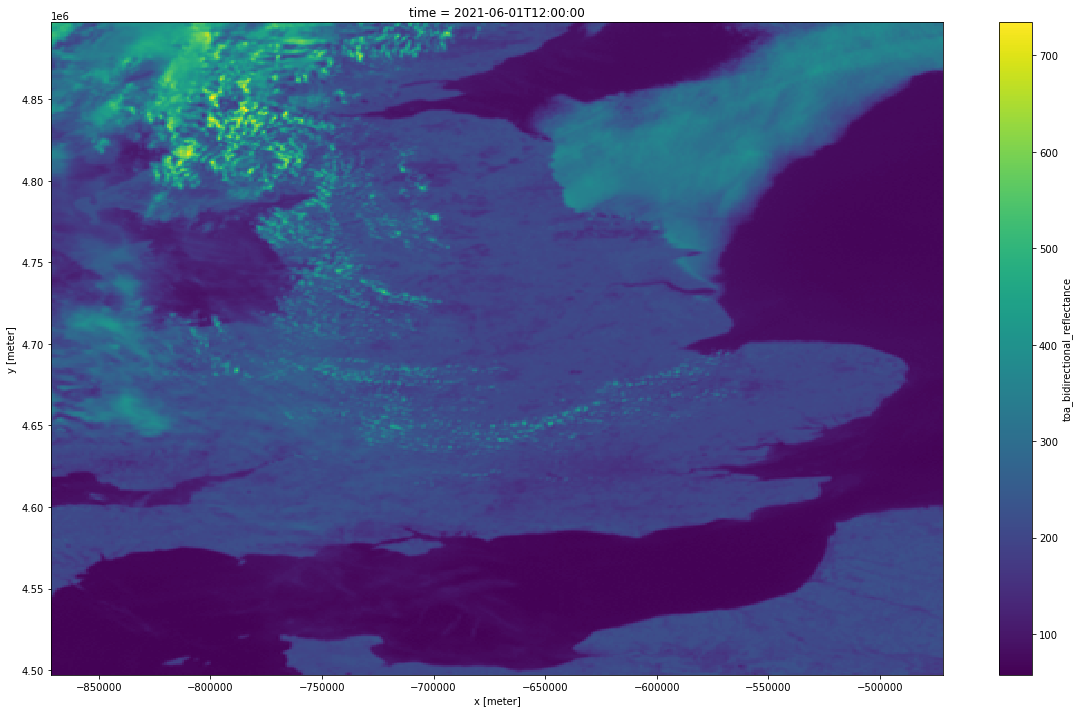

In [5]:
(opened["data"].isel(time=0, x=slice(500, 900), y=slice(300, 700))).plot();

In [6]:
(satellite_data_array.sel(time=DATETIME_TO_PLOT).isel(x=slice(500, 900), y=slice(300, 700)) / 4).plot();

NameError: name 'satellite_data_array' is not defined